# MNIST CNN
### M. Johnson, Mar. 2, 2019

## Imports and Data Loading

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F

root = './data'

if not os.path.exists(root):
    os.mkdir(root)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST Dataset
# Transforms - Normalizing data and converting it to Tensor form
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Training Data
training_data = torchvision.datasets.MNIST(root=root,
                                           train=True,
                                           transform=trans,
                                           download=True)
# Testing Data
testing_data = torchvision.datasets.MNIST(root=root,
                                          train=False,
                                          transform=trans,
                                          download=True)

# Data Loader
batch_size = 100

# Training data
training_loader = torch.utils.data.DataLoader(dataset=training_data,
                                              batch_size=batch_size,
                                              shuffle=True)

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

validation_indices = []

def get_testing_and_validation_loaders(dataset, batch_size = 100, validation_split = .15):
    
    shuffle_dataset = True
    random_seed = 7

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices.append(val_indices)
    
    return train_loader, validation_loader       

In [3]:
testing_loader, validation_loader = get_testing_and_validation_loaders(testing_data)

In [4]:
for name, loader in zip(['training', 'validation', 'testing'],
             [training_loader, validation_loader, testing_loader]):
    print(f'{name} loader: {len(loader)} batches of {batch_size} samples.')

training loader: 600 batches of 100 samples.
validation loader: 15 batches of 100 samples.
testing loader: 85 batches of 100 samples.


## Model Architecture

In [5]:
# MnistConvNet
class MnistConvNet(nn.Module):
    def __init__(self):
        super(MnistConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        
        self.fc1 = nn.Linear(32*4*4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = x.view(-1, 32*4*4)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def name(self):
        return "mnist_gpu_m2"

## Model Training

In [6]:
# HPs
lr = 0.001 # 0.001 too small
momentum = 0.9

# Model
model = MnistConvNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum)

loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
num_epochs = 10
for epoch in range(num_epochs):
    
    
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(training_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)
          
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/10], Loss: 0.05187, Acc: 0.99
Epoch [2/10], Loss: 0.04589, Acc: 0.99
Epoch [3/10], Loss: 0.05399, Acc: 0.98
Epoch [4/10], Loss: 0.04071, Acc: 0.98
Epoch [5/10], Loss: 0.03327, Acc: 0.99
Epoch [6/10], Loss: 0.02596, Acc: 0.99
Epoch [7/10], Loss: 0.02479, Acc: 0.99
Epoch [8/10], Loss: 0.02969, Acc: 0.99
Epoch [9/10], Loss: 0.02553, Acc: 0.99
Epoch [10/10], Loss: 0.03784, Acc: 0.99


## Model Evaluation

In [7]:
# Saving the model
torch.save(model.state_dict(), model.name())

# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(testing_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 0.03355, Acc: 0.99


### Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)

cm

array([[829,   0,   2,   0,   0,   0,   1,   2,   2,   0],
       [  0, 955,   0,   1,   0,   1,   1,   2,   3,   0],
       [  2,   1, 888,   0,   0,   0,   0,   4,   0,   0],
       [  0,   0,   1, 859,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 819,   0,   0,   0,   0,   6],
       [  2,   0,   0,   7,   0, 752,   1,   0,   0,   1],
       [  4,   2,   0,   0,   3,   1, 789,   0,   1,   0],
       [  0,   1,   2,   0,   0,   0,   0, 877,   0,   1],
       [  3,   0,   1,   1,   0,   0,   1,   0, 813,   1],
       [  0,   0,   0,   1,   2,   4,   0,   0,   1, 849]])

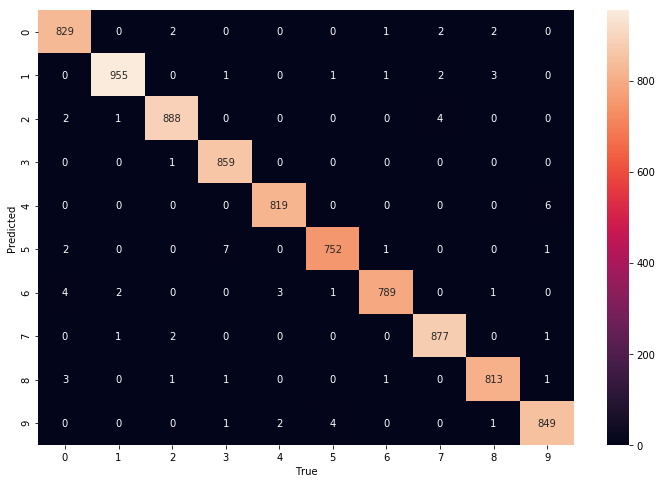

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,8));
sns.heatmap(cm, annot=True, fmt='g');
plt.xlabel('True');
plt.ylabel('Predicted');

## Classification Report
- Precision, Recall, etc.

In [10]:
from sklearn.metrics import classification_report

target_names = [str(i) for i in range(10)]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       836
           1       1.00      0.99      0.99       963
           2       0.99      0.99      0.99       895
           3       0.99      1.00      0.99       860
           4       0.99      0.99      0.99       825
           5       0.99      0.99      0.99       763
           6       0.99      0.99      0.99       800
           7       0.99      1.00      0.99       881
           8       0.99      0.99      0.99       820
           9       0.99      0.99      0.99       857

   micro avg       0.99      0.99      0.99      8500
   macro avg       0.99      0.99      0.99      8500
weighted avg       0.99      0.99      0.99      8500



### Loss visualization

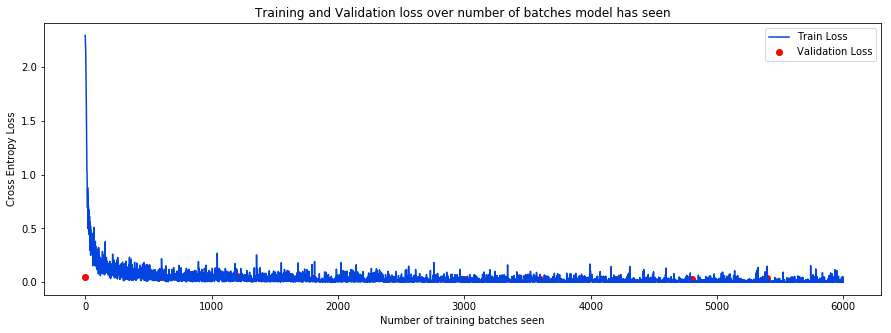

In [11]:
loader_len = len(training_loader)
x_vals= [loader_len*i for i in range(num_epochs)]
y_vals = loss_list

plt.subplots(figsize=(15,5))
plt.plot(train_losses2, color='xkcd:blue');
plt.scatter(x=x_vals, y=loss_list, color='red'); # validation losses
#plt.scatter(x=x_vals, y=acc_list, color='xkcd:green') # accs
plt.title('Training and Validation loss over number of batches model has seen');
plt.xlabel('Number of training batches seen');
plt.ylabel('Cross Entropy Loss');
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right');